# Data Assimilation with GPS Data

This project demonstrates the Ensemble Kalman Filter (EnKF) using real GPS data procured from two phones measuring the location of the same thing (me driving my car around a parking lot). It is meant as a hands-on experience in overcoming each obstacle of real-world data assimilation, including asynchronous and irregularly-spaced observations that don't directly map to the timing of the state model, and obtaining a solid initial $\mathbf{R}$ matrix. The second issue is determining the accuracy of the model - for my case, I was able to make an approximate "true" solution by mapping out my route using an online tool. 

<img src = "../img/routes.png" height = 300 width = 300/>

## Plotting the data

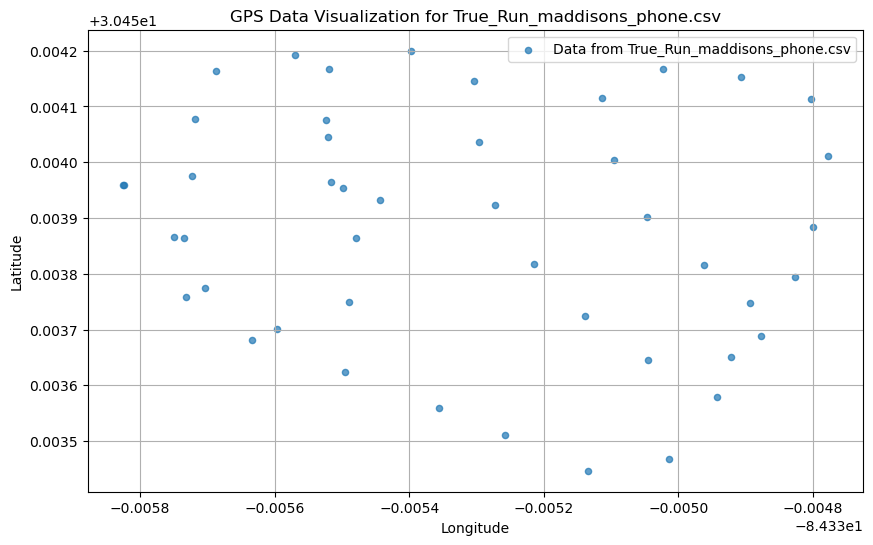

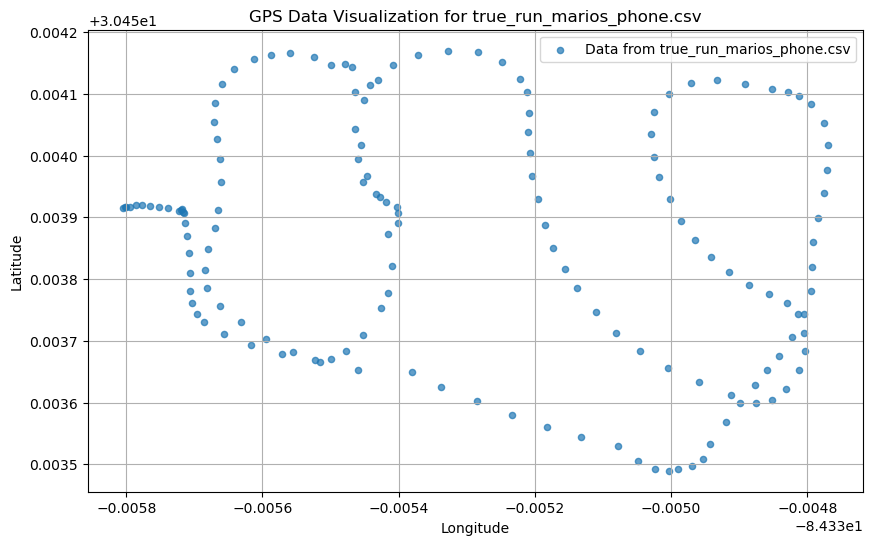

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_gps_data(file_path):
    # Load data
    data = pd.read_csv(file_path)
    
    # Check the data format and extract coordinates
        # Assuming 'lat' and 'long' columns for Maddison's phone data
    latitudes = data['Latitude']
    longitudes = data['Longitude']

    
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(longitudes, latitudes, alpha=0.7, marker='o', s=20, label=f'Data from {file_path.split("/")[-1]}')
    plt.title(f'GPS Data Visualization for {file_path.split("/")[-1]}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.legend()
    plt.show()

# Paths to the datasets
mm_file_path = '../data/True_Run_maddisons_phone.csv'
ms_file_path = '../data/true_run_marios_phone.csv'

# Plotting each dataset
plot_gps_data(mm_file_path)
plot_gps_data(ms_file_path)


## Interpolating the observations

In [36]:
import pandas as pd
from scipy.interpolate import interp1d
import numpy as np

def interpolate_gps_data(file_path, freq='2s', method='linear'):
    # Load data
    data = pd.read_csv(file_path)
    
    # Strip off any irregular timezone strings and convert to datetime
    data['Datetime'] = data['Datetime'].str.slice(stop=-3)
    data['Datetime'] = pd.to_datetime(data['Datetime'], format='%Y/%m/%d %H:%M:%S', errors='coerce')
    
    # Set as index
    data.set_index('Datetime', inplace=True)
    
    # Trim data to remove leading/trailing NaNs in resampling
    data = data[~data['Longitude'].isna()]
    start, end = data.index.min(), data.index.max()

    # Resample within the data range
    data_resampled = data.resample(freq).interpolate(method=method)
    
    # If linear interpolation leaves NaNs, consider using spline for larger gaps
    if data_resampled.isna().any().any() and method == 'linear':
        # Create an interpolation function based on existing data points
        # Using time in seconds since the start for spline interpolation
        time_seconds = (data.index - start).total_seconds()
        spline_func_lon = interp1d(time_seconds, data['Longitude'], kind='cubic', fill_value="extrapolate")
        spline_func_lat = interp1d(time_seconds, data['Latitude'], kind='cubic', fill_value="extrapolate")
        
        # Create a new time index for resampling and interpolate
        freq_seconds = int(freq[:-1])  # Extract numerical part and convert to int
        new_time_index = np.arange(time_seconds[0], time_seconds[-1] + 1, freq_seconds)
        new_datetimes = [start + pd.Timedelta(seconds=int(sec)) for sec in new_time_index]
        
        longitude_interp = spline_func_lon(new_time_index)
        latitude_interp = spline_func_lat(new_time_index)
        
        data_resampled = pd.DataFrame({'Longitude': longitude_interp, 'Latitude': latitude_interp}, index=new_datetimes)

    return data_resampled

# Paths to the datasets
mm_file_path = '../data/True_Run_maddisons_phone.csv'
ms_file_path = '../data/True_run_marios_phone.csv'

# Interpolate each dataset, trying cubic spline if linear leaves NaNs
mm_resampled = interpolate_gps_data(mm_file_path, method='linear')
ms_resampled = interpolate_gps_data(ms_file_path, method='linear')

# Display some of the interpolated data to verify
print(mm_resampled.head())
print(ms_resampled.head())


                     Longitude   Latitude
2024-04-25 01:27:51 -84.335825  30.453959
2024-04-25 01:27:53 -84.335822  30.453961
2024-04-25 01:27:55 -84.335815  30.453968
2024-04-25 01:27:57 -84.335805  30.453976
2024-04-25 01:27:59 -84.335793  30.453983
                     Longitude   Latitude
Datetime                                 
2024-04-25 01:27:52 -84.335804  30.453916
2024-04-25 01:27:54 -84.335801  30.453917
2024-04-25 01:27:56 -84.335786  30.453920
2024-04-25 01:27:58 -84.335765  30.453919
2024-04-25 01:28:00 -84.335738  30.453914


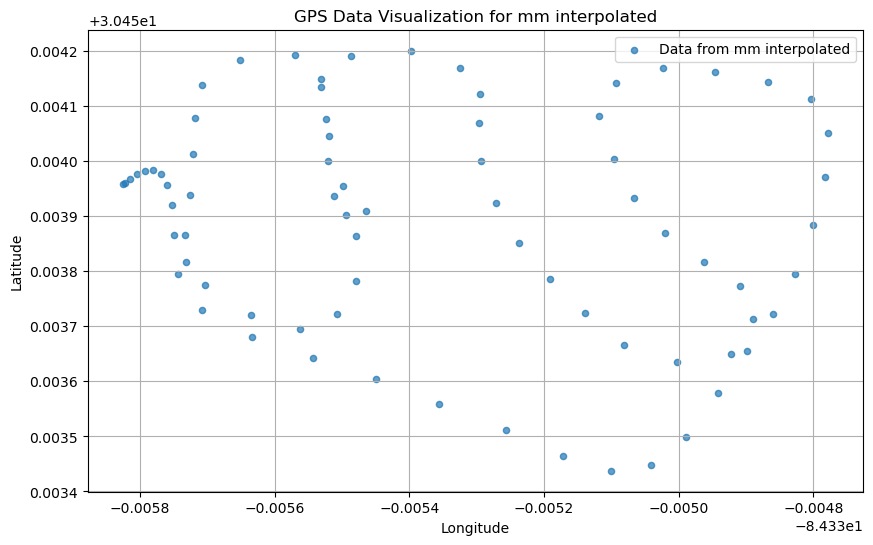

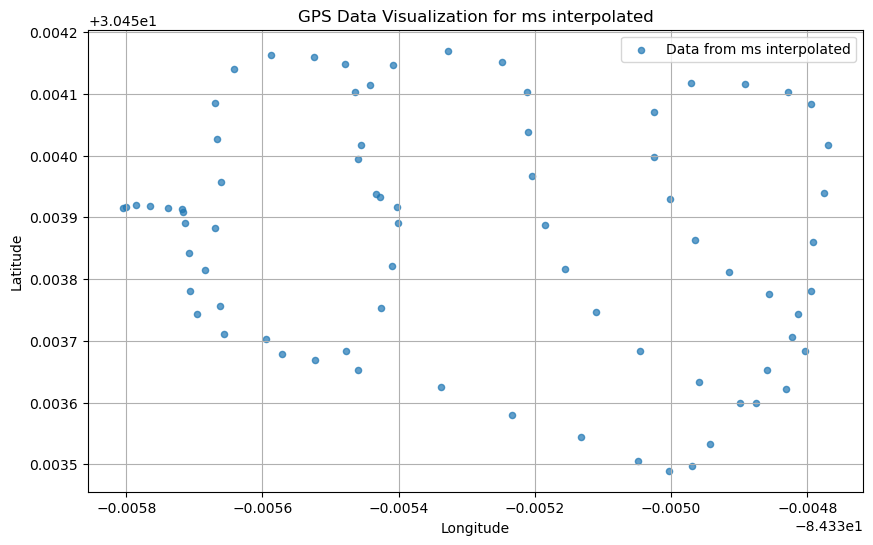

In [40]:
# Check the data format and extract coordinates
    # Assuming 'lat' and 'long' columns for Maddison's phone data
def plot_gps_data(data, name):
    latitudes = data['Latitude']
    longitudes = data['Longitude']


    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(longitudes, latitudes, alpha=0.7, marker='o', s=20, label=f'Data from {name}')
    plt.title(f'GPS Data Visualization for {name}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.legend()
    plt.show()

# Plotting each dataset
plot_gps_data(mm_resampled, 'mm interpolated')
plot_gps_data(ms_resampled, 'ms interpolated')

## Generating the $\mathbf{R}$ matrix